# Ingredient Standardization via Machine Translation

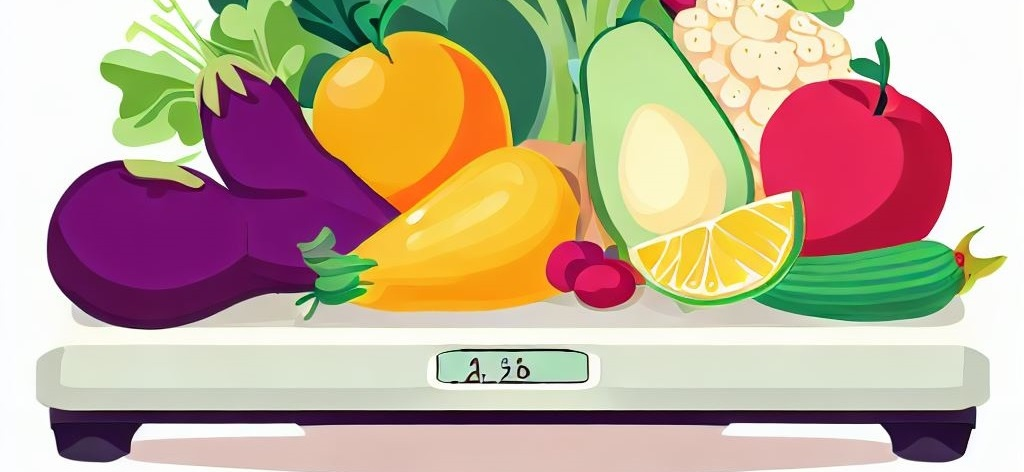


# Motivation

Great news!  You've just been hired as the CTO of *NutriMetrix*, a startup that has just raised a \$8M seed round and is backed by YCombinator and Sequoia. 

*NutriMetrix*'s main product is a mobile app of the same name.  It's similar to other nutrition and calorie-counting apps in that it can add up and track calories and food macros for you, but it's different in that you don't have to type them in.  You can just take a picture of the recipe with your phone and *NutriMetrix* will automatically track the calories just from the picture.

*NutriMetrix* also comes with a million recipes built into it, if you are a premium subscriber.  Or at least, that's the plan.  The previous CTO had asked the engineers to scrape the web for these millions of recipes.  That worked, for the most part.  **The problem is, all of recipes are formatted kindof differently, sometimes spelling out ingredient amounts and sometimes using numbers, for example.**  And the rest of the mobile app needs to store these recipes in a database using actual ingredients as entries in the `Ingredients` table.  The backend team would like these formatted as JSON strings for ease of integration.  **They need to be a standardized format so that the tool can properly add the calories tracked from the actual quantity and units of a particular ingredient**.

The previous CTO had tried to have his engineers come up with a simple `if-else` rules-based parser to try to munge the millions of ingredients from the web-scraped data into a standardized format.  But the code was a mess, tedious to write and maintain, and worst of all, it didn't work very well.  Every time they thought they had the rules right, another recipe would come along that would break the parser.  

And that's why that CTO was fired and you've been brought on.  Let's solve this problem with AI! 🤖

# Ingredient Formatting Details

This notebook will experiment with standardizing messy recipe ingredient data into a simplified JSON-ish format. In one sense, it can be thought of as a many-to-many sequence translation model. We'll test if a translation model can turn, say, the strings:

> "1 can pinto beans"  
> "3 tsp. cumin"  
> "2 cups shredded cheddar cheese"  
> "8 hamburger buns"  

into something like:

> { qty: 1, unit: can, item: pinto beans, mod: None }   
> { qty: 3, unit: teaspoon, item: cumin, mod: None }   
> { qty: 2, unit: cup, item: cheddar cheese, mod: shredded }   
> { qty: 8, unit: count, item: hamburger buns }   

The backend team needs items broken out into a integer or floating point `qty`, a standarized unit of measurement, such as `cup` or `teaspoon`, the `item` itself (which the backend team has protein, carb, fat, and calorie stats on already), and also a possible ingredient `mod` if the ingredient requires some slight prepwork or modifications.

This challenge is a bit harder than it looks.  Note that "shredded cheddar cheese" can be converted to "cheddar cheese, shredded", once reconstructed into `item` and `modifier`.  Also note that "cheddar cheese", "hamburger buns", and "pinto beans" are all non-separable nouns, versus say `cheese` with the modifier `cheddar` would be incorrect.  The system needs to learn that modifiers are typically preparation actions, such as `diced` or `chopped`.  Also note that the system has to learn that "8 hamburger buns" has a `unit` of "count".

<div class="alert alert-info">
    <strong>
    To make things a bit simplified, we're dropping the quotation marks around the keys and values that would normally be required for JSON.  The quotation marks aren't really needed for this toy example and our focus is just whether machine translation can do this task, not to get lost in dealing with the details of formatting.
    </strong>
</div>

# Where will we get all the labeled data?

We want to train a model that can take in a chunk of text containing recipe ingredients and iterate, line-by-line, on the data, converting each line into a standardized JSON format that contains the quantity, units, and item information.  If you think about it, this is a crude form of machine translation.  In NLP, it would be called a many-to-many problem where we are taking in a sequence of text and generating an output sequence that is different from the input.  See [this classic blog post by Andrej Karpathy](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) where I believe this many-to-many nomenclature comes from.

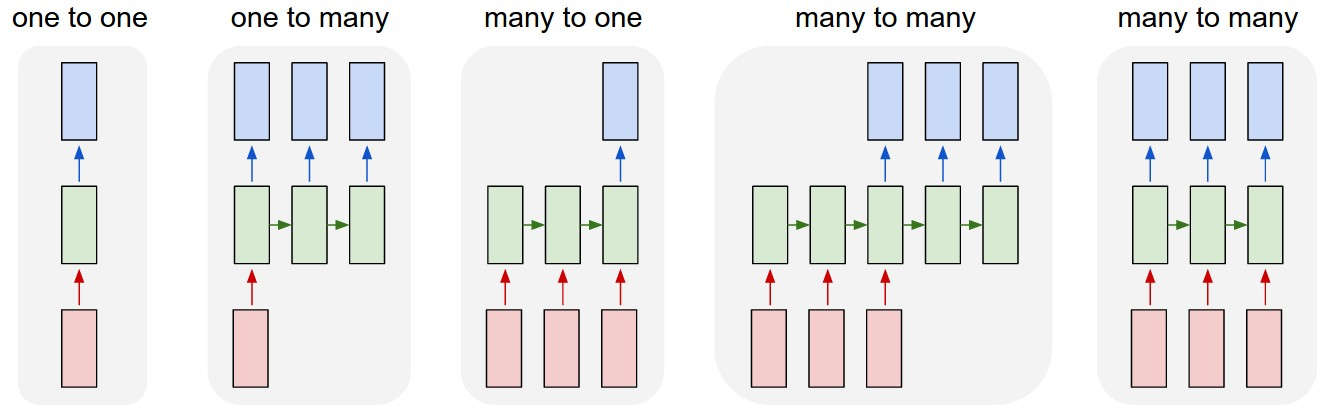
<figure>
    <figcaption align="center"><i>Language translation as many-to-many sequence (source: Karpathy)</i></figcaption>
</figure>

However, machine translation (for example, English to French) requires a large amount of labeled data of equivalent phrases in each language.  How are we going to find such a niche dataset for our problem that has loosely-structured recipe ingredient data, and the corresponding tidied data?  

# Synthetic Data

The beauty of this particular problem is we can instead *create* the dataset!  One of the coolest topics in AI in my opinion is synthetic data, or, making the data that you need.  Because we can create the data from random text, we automatically get all the labels for free.  And we can make as much data as we need, there is no limit besides those imposed by training time or hardware resources.

For example, let's say we want the following input:

> "3 dozen scrambled eggs"

to lead to the following JSON-ish-structured output:

> { qty: 36, unit: count, item: eggs, mod: scrambled }

Note that the translation not only added JSON formatting (you might think of this as syntax formatting in any language, like the capitalization of nouns in German, for instance), but it also memorized some simple conversions (3 dozen = 36), learned that for eggs the units are *counts* instead of, say, *cups*, and it also learned that the items will begin with the actual noun and adjectives such as *scrambled* will come last after a comma.  This is a pretty common structure in most cookbook recipes, for example, to find "2 cups onion, chopped".

**Because hand-labeling data is for the birds..**

Making our synthetic dataset is fairly straightforward and kinda fun.  We just need to reverse the inputs (X) and outputs (Y) to get an automatically-labeled dataset.  We'll see how this works with the code, but in short, we'll create a function which makes random batches of labeled ingredient data.  We'll choose random items, randomly choose adjective modifiers, and randomly choose quantities and units.  

In other words, we'll first build the JSON string from some random components and that creates our output, Y.  We then turn that into a similar input string, X, that has some randomized elements to contribute to the simulated diversity of messy internet-sourced data.  

Note that since we're not restricting it to sensical data, we'll very likely end up with data like:

> 7 teaspoons reduced wheat bread

or

> 1 basket frozen eggs

This should be OK and should make our model very robust and generalize well.  We can always create more data, and more data is always better!

## Memory Implications

When dealing with large datasets, it can be an issue getting potentially millions of training inputs stored in memory.  Or saving these generated synthetic data strings to disk will slow down performance and use a lot of disk space.  Fortunately, we don't need to do that.  Instead, one solution is to build a data **generator** (Python iterator type) that just yields one training batch at a time.  Because it can generate one batch while another is going through gradient descent on the GPU, it's very time efficient and utilizes system resources most efficiently.  It also avoids saving all the training data to disk, because we can just generate more on demand, without limits.

However, building a data generator instead of a typical function does add some complexity to the batching.  As it turns out, we can easily create 100,000 training sample phrases very quickly and store them entirely in RAM without using a generator at all.  Because the synthetic data in this case easily fits into RAM, and doesn't need to be saved to disk ever, I decided to stick with a traditional function instead of using a generator.  

<div class="alert alert-info">
    <strong>
💡 Just remember that if you cannot fit all the synthetic training data into RAM, generators are a good solution that can yield just one training batch at a time on the fly, for slightly more code complexity.
    </strong>
</div>

I think we understand the problem well enough, let's get coding..

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

import random

import numpy as np
import pandas as pd 
import os

In [ ]:
# These start as Python lists, let's convert them to Tensors

# We'll split at the same time, using only 10% of the sentences for validation
# Load ingredient data
# Option 1: If you have a CSV file with columns like 'raw' and 'standard'
# df = pd.read_csv('ingredients_data.csv')
# x = df['raw'].tolist()  # Raw ingredient inputs
# y = df['standard'].tolist()  # Standardized outputs

# Option 2: For demo purposes, create sample data
x = [
    "1 cup diced red bell pepper",
    "2 tablespoons olive oil",
    "1/2 lb skinless chicken breast",
    "3 cloves of garlic, minced",
    "one tablespoon fresh lemon juice",
    "1/4 teaspoon kosher salt"
]

y = [
    "red bell pepper, 1 cup, diced",
    "olive oil, 2 tablespoons",
    "chicken breast, 0.5 pound, skinless",
    "garlic, 3 cloves, minced",
    "lemon juice, 1 tablespoon, fresh",
    "salt, 0.25 teaspoon, kosher"
]

# Set the total number of examples
N_TRAINING = len(x)
print(f"Total examples: {N_TRAINING}")

train_size = int(0.9 * N_TRAINING)

encoder_input_train = tf.convert_to_tensor(x[:train_size])
encoder_input_val = tf.convert_to_tensor(x[train_size:])

# NOTE!
# Inputs to the decoder are based on Y (the right answer) because using teacher forcing
# In other words, what we're putting into the decoder at each time step is what we
# want it to end up predicting at the end of that timestep.  So these are shifted in time.
decoder_input_train = tf.convert_to_tensor([f"startofseq {s}" for s in y[:train_size]])
decoder_input_val = tf.convert_to_tensor([f"startofseq {s}" for s in y[train_size:]])

# Here we're actually using the layer since we need these to be integer tokens, not strings anymore
decoder_targets_train = text_vec_layer_y([f"{s} endofseq" for s in y[:train_size]])
decoder_targets_val = text_vec_layer_y([f"{s} endofseq" for s in y[train_size:]])

print(f"encoder_input_train.shape: {encoder_input_train.shape}")
print(f"decoder_input_train.shape: {decoder_input_train.shape}")
print(f"decoder_targets_train.shape: {decoder_targets_train.shape}")
print("\nAn example of the first one of each of these:\n")
print(f"encoder_input_train[0].numpy(): {encoder_input_train[0].numpy()}")
print(f"decoder_input_train[0].numpy(): {decoder_input_train[0].numpy()}")
print(f"decoder_targets_train[0].numpy(): {decoder_targets_train[0].numpy()}")


# Load Ingredients dataset

I'm using the Kaggle recipe-ingredients-dataset to just grab a list of raw ingredients.  

## Raw Ingredients

In [ ]:
# Using the Kaggle Recipe-Ingredients Dataset just to get lists of names of ingredients

# Load the ingredients from disk
import json

raw_ingredients = set()  # we'll eliminate duplicates using sets

with open('train.json') as fr:
    data_ing = json.load(fr)

# the file is a list of dictionaries.  iterate over list of dictionaries (a recipe)
for d in data_ing:
    # get all the ingredients in this recipe into a list
    ing = [x for x in d['ingredients']]
    # add each ingredient to the set, eliminating duplicates
    for i in ing:
        raw_ingredients.add(i)

# Convert set of ingredients to list
raw_ingredients_l = list(raw_ingredients)

# Look at a few
print(f"Length of ingredients list: {len(raw_ingredients_l)}")
print(f"First 10 example ingredients: {[r for r in raw_ingredients_l[:10]]}")

We loaded the dataset and added each ingredient to a set to eliminate duplicates, then converted that to a list at the end for easier manipulation.  This gives us 6,714 raw ingredients to permute over.

## Modifiers

In [ ]:
# Next, build a list of adjectives, like "diced" or "blanched"
mods_set = set()

# Found these online and they aren't that long, so just manually typed in some lists
mods_l_1 = ['baked', 'blanched', 'blackened', 'braised', 'breaded', 'broiled', 'caramelized', 'charred', 'fermented', 'fried',
         'glazed', 'infused', 'marinated', 'poached', 'roasted', 'sauteed', 'seared', 'smoked', 'whipped']

# -ed adjectives.  Found another good list online.
# Some overlap in these lists, which is why we're using sets!
mods_l_2 = ['diced', 'battered', 'blackened', 'blanched', 'blended', 'boiled', 'boned', 'braised', 'brewed', 'broiled',
           'browned', 'butterflied', 'candied', 'canned', 'caramelized', 'charred', 'chilled', 'chopped', 'clarified', 
           'condensed', 'creamed', 'crystalized', 'curdled', 'cured', 'curried', 'dehydrated', 'deviled', 'diluted',
           'dredged', 'drenched', 'dried', 'drizzled', 'dry roasted', 'dusted', 'escalloped', 'evaporated', 'fermented',
           'filled', 'folded', 'freeze dried', 'fricaseed', 'fried', 'glazed', 'granulated', 'grated', 'griddled', 'grilled',
           'hardboiled', 'homogenized', 'kneaded', 'malted', 'mashed', 'minced', 'mixed', 'medium', 'small', 'large', 
           'packed', 'pan-fried', 'parboiled', 'parched', 'pasteurized', 'peppered', 'pickled', 'powdered', 'preserved',
           'pulverized', 'pureed', 'redolent', 'reduced', 'refrigerated', 'chilled', 'roasted', 'rolled', 'salted',
           'saturated', 'scalded', 'scorched', 'scrambled', 'seared', 'seasoned', 'shredded', 'skimmed', 'sliced',
           'slivered', 'smothered', 'soaked', 'soft-boiled', 'hard-boiled', 'stewed', 'stuffed', 'toasted', 'whipped',
           'wilted', 'wrapped']

# Go over all lists and all words in list and add to modifications set
for a_list in [mods_l_1, mods_l_2]:
    for mod in a_list:
        mods_set.add(mod)
        
# Convert back to list and inspect
mods_l = list(mods_set)
print(f"Length of mods_list: {len(mods_l)}")

Similarly, I create a set of unique ingredient modifications, such as `blended` or `stuffed`.  For this I just searched around online and found some lists of food related adjectives, searching for ones that ended in "ed."  I hand-typed these in, but since there weren't that many, it wasn't too bad.  Since I am using multiple unrelated lists, I again use sets to guarantee uniqueness.  This results in 101 modifiers to permute over.

## Measurement Units

In [ ]:
# Do the same for units now
units_set = set()

# Found these online and they aren't that long, so just manually typed in some lists
units_l_1 = ['l', 'dl', 'milliliter', 'liter', 'deciliter', 'teaspoon', 't.', 'tsp.',
             'milliliters', 'liters', 'deciliters', 'teaspoons', 't.', 'tsp.',
            'tablespoon', 'T.', 'tbsp.', 'ounce', 'fl oz', 'cup', 'c.', 'pint', 'pt.',
            'tablespoons', 'ounces', 'fl ozs', 'cups', 'pints', 'quarts', 'gallons', 'grams', 'kilograms',
            'quart', 'qt.', 'gallon', 'gal', 'mg', 'milligram', 'g', 'gram', 'kg', 'kilogram', 'milligrams',
            'pound', 'lb', 'ounce', 'oz', 'count', 'pints', 'quarts', 'cups', 'tablespoons',
            'pounds', 'lbs', 'ounces', 'units', 'drops', 'tsps.', 'tbsps.', 'Ts.', 'ts.',
            'teaspoons', 'dash', 'pinch', 'drop', 'dram', 'smidgeon', 'dashes', 'pinches', 'drops', 
             'drams', 'smidgeons', ]

# Go over all lists and all words in list and add to modifications set
for a_list in [units_l_1]:
    for unit in a_list:
        units_set.add(unit)
        
# Convert back to list and inspect
units_l = list(units_set)
print(f"Length of units_list: {len(units_l)}")

Again, I hand-type a bunch of units of measurement commonly used in the cooking world.  My primary focus here was U.S./Imperial measures, but I threw in a few metric just for kicks.  Obviously you as the CTO of *NutriMetrix* will know better what geography you are focused on, or if you truly seek world dominance.  😉

Note that when we permute over random numbers and random units, the plurality is often not going to agree.  For example, we might get `1 drams` or `3 cup`.  This is OK, as we will see plenty of correct examples in the training data as well, and we're not trying to generate realistic sounding recipes, we're just using this to make training data.  Any real recipes that this runs on would have proper plural endings and will work just fine.

There are 62 unique units to permute over.

## Quantities

In [ ]:
# Now we'll do the same for our random numbers,
# but we'll add a little complexity by making a dictionary mapping
# so we can convert things like "dozen" to 12 and also take in text number inputs.
# The output from our model should be integers
qty_dict = {
    "1/2": 0.5,
    "1/4": 0.25,
    "1/3": 0.333,
    "2/3": 0.666,
    "3/4": 0.75,
    "half": 0.5,
    "third": 0.333,
    "quarter": 0.25,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10,
    "11": 11,
    "12": 12,
    "a dozen": 12,
    "a baker's dozen": 13,
    "two dozen": 24,
    "three dozen": 36,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12
}

Here we mapped numbers represented as strings into their integer or floating point numerical equivalents.  We want to handle recipes that list the numerical representations (`3`) as well as text representations (`three`).  Also note here that I handle common fractions, and some more rare baking nomenclatures such as `dozen` or `baker's dozen`.  So this translation model isn't learning to do math, we've simply taught it a few conversions it can memorize.

# Synthetic Training Data Generation

Let's now write our function that will build the training data, labeled X/Y pairs.

<div class="alert alert-info">
  <strong>
      Again, note that we'll actually build a simplified JSON format that doesn't have the " " marks in them, for simplicity's sake.  We'll preprocess the inputs and outputs to both put spaces around commas and the { and } tokens as well, which will then allow it to keep those tokens in, which are important for JSON.
  </strong>
</div>

The following code will randomly permute over the 1.5 billion possible permutations of all the ingredients, modifiers, units, and quantities to generate as many training samples as is called for.  

In [ ]:
# We're now ready to make our function which creates a number of samples of labeled training data
import random
# Remember, we want the model to convert
# X = "3 dozen scrambled eggs" to
# Y = {"qty": 36, "unit": "count", "item": "eggs", "mod": "scrambled"}
# but we really will start with the answer (Y) and from that create the input (X)

# Generate Ingredient Data
def gen_ing_data(num_samples):
    
    # Python lists
    X = [0] * num_samples  # make an empty list of num_samples elements
    Y = [0] * num_samples  # same for Y

    # For each example to make..
    for i in range(num_samples):

        # Pick a random qty.  random.choice() chooses from a list
        rnd_qty_str, rnd_qty_int = random.choice(list(qty_dict.items()))

        # Pick a random unit
        rnd_unit = random.choice(units_l)

        # Pick a random modifier.  Only do this 1/3 of the time
        rnd_mod_present = random.choice([None, None, True])

        # If the modifier is going to be used, select one randomly
        rnd_mod = random.choice(mods_l)

        # Pick a random item
        rnd_ing = random.choice(raw_ingredients_l)

        # Build the output string, Y
        # e.g. {"qty": 36, "unit": "count", "item": "eggs", "mod": "scrambled"}
        # NOTE: using ' ' at beginning means we don't have to escape ""
        # NOTE: {{ and }} are literal escapes for printing a single { or } character, instead of backslash
        # when using a formatted f-string.

        # Also, about a fifth of the time, we'll randomly use no units at all.
        # This will simulate 'count' as the quantity
        # e.g. 5 pickles, chopped
        no_units_present = random.choice([False, False, False, False, True])
        if no_units_present:
            rnd_unit = 'count'  # For purposes of building Y
            # NOTE: Can still rarely but occasionally see "count" in the in the input X of an ingredient,
            # because "count" is actually a unit in the list.  Some recipes might say this!

        # Just have to have an 'if' here because we can't conditionally and easily print the double quotes (I tried..)
        if rnd_mod_present:
            Y[i] = f'{{ qty: {rnd_qty_int} , unit: {rnd_unit} , item: {rnd_ing} , mod: {rnd_mod} }}'
        else:
            Y[i] = f'{{ qty: {rnd_qty_int} , unit: {rnd_unit} , item: {rnd_ing} , mod: {None} }}'

        # Build the input string, X
        # e.g. "3 dozen scrambled eggs"

        # About half the time, just for training it to be more robust, we'll put the mod at the end with a comma
        # e.g. 3 dozen eggs, scrambled
        # The rest of the time, it will come before the ingredient
        # e.g. 3 dozen scrambled eggs
        mod_at_end = [False, True]
        rnd_mod_at_end = random.choice(mod_at_end)

        # A little complex seeming, but done this way to avoid double spaces like "3  eggs"
        if rnd_mod_present:
            if no_units_present:
                if rnd_mod_at_end:
                    X[i] = f'{rnd_qty_str} {rnd_ing} , {rnd_mod}'             # e.g. 3 eggs, scrambled
                else:
                    X[i] = f'{rnd_qty_str} {rnd_mod} {rnd_ing}'              # e.g. 3 scrambled eggs
            else:
                if rnd_mod_at_end:
                    X[i] = f'{rnd_qty_str} {rnd_unit} {rnd_ing} , {rnd_mod}'  # e.g. 3 cups eggs, scrambled
                else:
                    X[i] = f'{rnd_qty_str} {rnd_unit} {rnd_mod} {rnd_ing}'   # e.g. 3 cups scrambled eggs
        else:
            if no_units_present:
                X[i] = f'{rnd_qty_str} {rnd_ing}'                            # e.g. 3 eggs
            else:
                X[i] = f'{rnd_qty_str} {rnd_unit} {rnd_ing}'                 # e.g. 3 cups eggs

    return ((X, Y))

We use the `random` library and especially the `random.choice()` function quite liberally to generate the training data.  A couple things are worth pointing out:

* About a third of the time, we add a random modifier to the ingredient, like "diced"
* If there is a modifier, then half of the time we add it to the end of the ingredient with a comma (`3 cups pickles, chopped`) and the rest of the time as a simple prepended adjective (`3 cups chopped pickles`).  This variation happens often in human language in real cooking recipes, so we want the data robust to handle all cases.
* A fifth of the time, we don't include any units at all (`3 pickles`).  The unit entered into the structured JSON output, Y, is `unit: count`
* Another slight modification we make to the JSON format at this point is placing spaces around the tokens and the commas in the outputs, Y.  For example `{ qty: 36 , unit: count , item: eggs , mod: scrambled }` instead of `{ qty: 36, unit: count, item: eggs, mod: scrambled }`.  This makes it easier to just use the default "split on whitespace" option for the Keras TextVectorization layer we'll use later on for tokenization.

## Now Actually Make the Data

In [ ]:
N_TRAINING = 100_000

# These are still Python lists at this point
x, y = gen_ing_data(N_TRAINING)

for i in range(15):
    print(f"{x[i]}  ==>  {y[i]}")

Looks pretty good!  I see mixes of the quantity being in integers and also text strings, as well as some where there are no units (unit "count") for items, as well as a mix of no modifiers, modifiers at the front, and at the end.  🔥

# Seq2Seq Model

For this task, I chose to model this as a translation task and to use the Seq2Seq (sequence-to-sequence) model originally invented by Google in [this classic paper](https://arxiv.org/pdf/1409.3215.pdf).  

It's based on an encoder-decoder architecture.  Seq2Seq is a very important model in NLP and has been used successfully on such tasks as translation, text summarization, image captioning, speech recognition, and chatbots.  There are more powerful models out there than this today, such as those based on attention models.  But for simpler tasks, a recurrent Seq2Seq model can be good enough, and is an important part of a foundational understanding in NLP.

I'm not going to deep dive into how Seq2Seq models work — you can read the original paper linked above and there are plenty of great blogs and tutorial writeups about it elsewhere.  But in a nutshell, it's an architecture used for tasks involving sequences of text.  It consists of an encoder, which encodes an input sequence into a context vector (sometimes called the "thought vector" or the "context vector."  I personally prefer the term "notion vector," but I believe I'm the only person who says that.. let's make "notion vector" happen! 😀).  This vector captures the essence of a particular input sequence.  Finally, a decoder generates an output sequence based on that context vector.  This model works well even for tasks where the length of input and output sequences can vary.

# Word Tokenization (TextVectorization Layers)

In [ ]:
# Add these import statements at the top of your cell
import tensorflow as tf
from tensorflow import keras
# Let's treat this as a translation task and build a seq2seq model, like original Google paper

# Since we know all the words in our generated data, we can make a vocab that fits everything
# plus add 1 for padding token, 1 for <SOS> and <EOS> tokens, and 10 more just for commas, {, }, and so on just to be safe
print(f"{len(raw_ingredients_l) + len(mods_l) + len(units_l) + len(qty_dict)} unique words used for training")

# Above prints 6913 unique words used for making our dataset.  Let's round up to 7000 which will cover any padding, SOS/EOS tokens, punctuation, etc.
VOCAB_SIZE = 7000

# Find longest length of input or output text strings
max_len = -1
for i in range(N_TRAINING):
    x_tmp_len = len(x[i].split())
    y_tmp_len = len(y[i].split())
    if x_tmp_len > max_len:
        max_len = x_tmp_len
    if y_tmp_len > max_len:
        max_len = y_tmp_len
        
print(f"Longest number of words in input or output: {max_len}")  # Prints 18

MAX_LENGTH = 25  # just to be safe upon random re-runs, we'll use padding to pad all sequeneces to this number of tokens

# Use a Keras TextVectorization layer to tokenize the text in a way that can be run efficiently on GPUs
# NOTE: We need to use None for standardization, because the default is to lowercase and remove punctuation.
# However, since our output Y strings are formatted JSON, the punctuation is very important and can't be stripped! 
# All the text is already lowercase.
#
# Additionally, for how to split, we need to use a custom callable function.  The default of splitting on whitespace
# does not work for us, as that would leave tokens as like "chicken," (when "chicken, diced" is split)
# Same for like:
# six quarts poblano chilies, infused  ==>  {"qty": 6, "unit": "quarts", "item": "poblano chilies", "mod": "infused"}
#
# So we want to tokenize X on spaces AND commas
# And we want to tokenize Y on spaces, commas, colons, quotation marks, and { or }

# NOTE:
# Not sure why, but these functions didn't work.  Probably a formatting issue.
# Ended up using the Keras built-in split on whitespace and modified my data generation instead.
# Leaving in here for posterity's sake.

# Ended up modifying the training data to add space around commas and other JSON tokens so that we could use the
# whitespace-splitting built-in and still retain mostly JSON syntax.

def split_x(input_str):
    input_str = tf.strings.regex_replace(input_str, ',', ' , ')  # First turn ever comma into a comma surrounded by space
    return tf.strings.split(input_str, sep=' ')  # Then split on spaces, which will now keep the commas intact

def split_y(input_str):
    # Similary, we'll put space around special tokens so they remain as separate tokens
    input_str = tf.strings.regex_replace(input_str, ',', ' , ')
    input_str = tf.strings.regex_replace(input_str, ':', ' : ')
    input_str = tf.strings.regex_replace(input_str, '"', ' " ')
    input_str = tf.strings.regex_replace(input_str, '}', ' } ')
    input_str = tf.strings.regex_replace(input_str, '{', ' { ')
    return tf.strings.split(input_str, sep=' ')  # Then split on spaces to keep all tokens


# Layers (old way with custom split functions)
# text_vec_layer_x = keras.layers.TextVectorization(VOCAB_SIZE, standardize=None, split=split_x, output_sequence_length=MAX_LENGTH)
# text_vec_layer_y = keras.layers.TextVectorization(VOCAB_SIZE, standardize=None, split=split_y, output_sequence_length=MAX_LENGTH)

# NOTE: Trying this without the custom split functions, now that I've put the spaces directly into the strings!
# Maybe it was my custom function that was breaking things?
# output_sequence_length is where the padding gets implemented all to the same length.
text_vec_layer_x = keras.layers.TextVectorization(VOCAB_SIZE, standardize=None, split='whitespace', output_sequence_length=MAX_LENGTH)
text_vec_layer_y = keras.layers.TextVectorization(VOCAB_SIZE, standardize=None, split='whitespace', output_sequence_length=MAX_LENGTH)


# Now adapt on the training data
text_vec_layer_x.adapt(x)
text_vec_layer_y.adapt([f"startofseq {s} endofseq" for s in y])  # Need to add SOS and EOS tokens to the training data for training and inference

# Let's look at what the layers have adapted to.. top tokens
print(text_vec_layer_x.get_vocabulary()[:20])
print("")
print(text_vec_layer_y.get_vocabulary()[:20])


These results look as expected.  The most common tokens are padding tokens, then unknown tokens, and then some very common characters and words we see in the training data.

# Dataset Preparation

Now we'll prepare the input strings (currently Python lists) for training and inference by converting to Tensors.

We'll also split the data to create a validation set, and create sets that will be fed into the decoder part of the Seq2Seq architecture.  These have just the SOS token prepended to the input X strings, and have the EOS token appended to the output Y strings.  This strategy is called [teacher forcing](https://en.wikipedia.org/wiki/Teacher_forcing) and is used to tell the model what the next token should be during training, regardless of what the decoder predicted.  It greatly speeds up training, but obviously cannot be used for inference since we don't know what the correct predictions are ahead of time.

In [ ]:
# These start as Python lists, let's convert them to Tensors

# We'll split at the same time, using only 10% of the sentences for validation
train_size = int(0.9 * N_TRAINING)

encoder_input_train = tf.convert_to_tensor(x[:train_size])
encoder_input_val = tf.convert_to_tensor(x[train_size:])

# NOTE!
# Inputs to the decoder are based on Y (the right answer) because using teacher forcing
# In other words, what we're putting into the decoder at each time step is what we
# want it to end up predicting at the end of that timestep.  So these are shifted in time.
decoder_input_train = tf.convert_to_tensor([f"startofseq {s}" for s in y[:train_size]])
decoder_input_val = tf.convert_to_tensor([f"startofseq {s}" for s in y[train_size:]])

# Here we're actually using the layer since we need these to be integer tokens, not strings anymore
decoder_targets_train = text_vec_layer_y([f"{s} endofseq" for s in y[:train_size]])
decoder_targets_val = text_vec_layer_y([f"{s} endofseq" for s in y[train_size:]])

print(f"encoder_input_train.shape: {encoder_input_train.shape}")
print(f"decoder_input_train.shape: {decoder_input_train.shape}")
print(f"decoder_targets_train.shape: {decoder_targets_train.shape}")
print("\nAn example of the first one of each of these:\n")
print(f"encoder_input_train[0].numpy(): {encoder_input_train[0].numpy()}")
print(f"decoder_input_train[0].numpy(): {decoder_input_train[0].numpy()}")
print(f"decoder_targets_train[0].numpy(): {decoder_targets_train[0].numpy()}")


The encoder and decoder inputs are turned into tensors and are both 90% of the length as the original training data, as we expect.  They are still 1-dimensional at this point, being Numpy byte-array representations of strings (technically, they are still EagerTensor representations at this point).  
The output targets have the same number of samples, and have gone through the text encoding layer, so have length of MAX_LENGTH size (25).

We look at the first example of each of these, and we can see that encoder_input and decoder_input are still the string representations of the translations, and the decoder_targets are the tokenized desired outputs, plus padding at the end to get to MAX_LENGTH words.

# Start the Seq2Seq Model

Let's start putting together the rest of the model.

In [ ]:
# Start building parts of the model
encoder_inputs = keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
EMBED_SIZE = 128  # dimensionality of the word embeddings being learned.  128 was probably overkill for this task

encoder_input_ids = text_vec_layer_x(encoder_inputs)
decoder_input_ids = text_vec_layer_y(decoder_inputs)

print(f"encoder_input_ids.shape: {encoder_input_ids.shape}")
print(f"encoder_input_ids.dtype: {encoder_input_ids.dtype}\n")

encoder_embedding_layer = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True)  # Input dim. x Output dim. ==> (7000, 64)
decoder_embedding_layer = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True)  # Input dim. x Output dim. ==> (7000, 64)

# Using the Keras Functional API since not a simple Sequential model
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

print(f"encoder_embeddings.shape: {encoder_embeddings.shape}")
print(f"decoder_embeddings.shape: {decoder_embeddings.shape}")

As explained in more detail in my notebook [What Kaggle WON'T Tell You About Your Notebooks](https://www.kaggle.com/code/quackaddict7/what-kaggle-won-t-tell-you-about-your-notebooks/), we cannot feed pure strings into the model, computers only understand numbers.  So we pass the strings through the TextVectorization layers to turn them into token `ids`.  Even then, the model would not be able to learn anything in this form of representation where a number simply has an equivalent `id` standin.  

We need to put it through an `Embedding` layer, which allows the model to add dimensionality to words and therefore contain a richer representation for them.  Here I chose to make this 128-dimensional, which is probably overkill for this particular task.  We can see the shape of `encoder_input_ids` and `decoder_input_ids` that these are now encoded into the integer token representations.  Furthermore, after going through the Embedding layer, the tensors are mapped to a more complex n-dimensional word representation, as expected.

# Build the Encoder

In [ ]:
# Only the encoder can be Bidirectional because a bd decoder can't know the end tokens yet!
encoder = keras.layers.Bidirectional(keras.layers.LSTM(256, return_state=True))

# Explicitly unpack all 5 outputs from bidirectional LSTM
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_embeddings)

print("Encoder states and their shapes:")
print(f"forward_h: {forward_h}")
print(f"forward_c: {forward_c}")
print(f"backward_h: {backward_h}")
print(f"backward_c: {backward_c}")

# Use Keras layers for concatenation instead of tf.concat
state_h = keras.layers.Concatenate(axis=-1)([forward_h, backward_h])
state_c = keras.layers.Concatenate(axis=-1)([forward_c, backward_c])
encoder_state = [state_h, state_c]

print("\nConcatenated encoder states and shapes:")
for state in encoder_state:
    print(state)

In [ ]:
# But decoder LSTM needs to be twice the size of the encoder since bi-directional states are concatenated!
decoder = keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)  # Initialize the decoder with the saved state (c and h) from the encoder

print(f"decoder_outputs.shape: {decoder_outputs.shape}")

By printing out the shape of the tensor outputs, we see that the output of the decoder is 3-dimensional.  The first dimension `None` is Keras's way of saying that the layer could handle any number of samples deep (in this case, one giant batch).  The second dimension gives the length of the sequence, and the third dimension is an additional dimension added by the LSTM layer, equal to the number of units in the LSTM layer.  

Shortly, we will feed these outputs into a densely connected layer to make predictions for what is the next most likely output word.

Note that we return the sequences from the decoder, so that we get the outputs at each step in time (otherwise we would only get the last one).  These outputs will go into a Dense layer for predicting the next word (Keras now automatically handles the fact that we're feeding a sequence into the Dense layer, and we do not need to use a `TimeDistributed` Dense layer).

<div class="alert alert-info">
  <strong>Implementation Note.</strong>
    Some Seq2Seq architectures also return the <b>state</b> from the decoder, but we don't need that here.  The reason they need that is those designs redefine a new model to use for inference.  Here, we're reusing our model for inference and so we do not need the decoder state.  We always initialize the decoder in this design with the encoder state.
</div>

Let's feed the decoder outputs into the Dense layer classifier now.

In [ ]:
output_layer = keras.layers.Dense(VOCAB_SIZE, activation="softmax")  # Predict most likely word across all possible vocab words
Y_probabilities = output_layer(decoder_outputs)

print(f"Y_probabilities.shape: {Y_probabilities.shape}")

The outputs of the decoder LSTM were fed into a **Dense** layer to make predictions for the next target word.  Again, we didn't need to use a TimeDistributed Dense layer, even though we're using an RNN here, because Keras now supports this automatically with standard Dense layers.  

We use VOCAB_SIZE number of neurons/outputs in the fully-connected Dense layer because we need it to calculate the probability of the next word predicted across every word in the entire vocabulary.  Thus we again have a 3-dimensional output shape.

# Compile the Model

In [ ]:
model = keras.Model(inputs=[encoder_inputs, decoder_inputs],
                   outputs=[Y_probabilities])

model.compile(loss="sparse_categorical_crossentropy",  # sparse because each word token gets its own number (not one-hot)
             optimizer="nadam",
             metrics=['accuracy'])

model.summary()

At this point, it's fairly straightforward stuff to compile and train our model.  Note that because each input word gets its own token, we'll use `SparseCategoricalCrossentropy` for our loss function.  

It's a fairly sizeable model at 7.5M parameters.

# Plot the Model

Here we'll use Keras's `plot_model()` function to give a visual check over of the model we just built.  

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='seq2seq_model.png', show_shapes=True, show_dtype=True)

# Training Time!

In [ ]:
EPOCHS = 11  # Each epoch takes about 3 minutes on a P100 GPU
             # Found experimentally to give good results

model.fit((encoder_input_train, decoder_input_train), decoder_targets_train,
         epochs=EPOCHS,
         validation_data=((encoder_input_val, decoder_input_val), decoder_targets_val))

# TODO:
# Make more performant with prefetching.  Currently GPU is a bit data starved.  
# Here is where using a generator set up for CPU prefetching would probably help a lot.

# Predicting and Translating Sequences

Now that the model is trained, we'll need to write a custom loop function to actually perform the translation.  This is because our model is set up to only predict the next word given an input sequence.

The basic pseudocode for our translation function is as follows:
1. Place the input string (to be translated) on the encoder input.  (Of course, after tokenization).
2. Place just the `<SOS>` or start-of-sequence token on the input to the decoder.
   * This is our current working output translation string.
3. As our model is defined, this will cause the context vector to be created by the encoder, and the resulting encoder states to pre-condition the decoder.  The decoder will then predict the next output word.  
   * The model will output probabilities for the target words, Y.
   * We use `argmax()` to find the word `id` with the highest probability.
   * We convert that `id` to the word using the TextVectorization layer's `.get_vocabulary()` method.
4. If the predicted next word is the `<EOS>` or end-of-sequence token, or we've hit then max length, then we're all done with the translation.
5. Otherwise, we append the predicted next word to our translation string and jump back to Step 2, placing the now-one-word-longer output translation string on the decoder's input.

In [ ]:
# Convert unformatted ingredients to their JSON formatted equivalents
def translate(ingredient_string):
    # Start with a blank string for our output translation string
    translation = ""
    # Iterate up to max sequence length times
    for word_idx in range(MAX_LENGTH):
        x_enc = np.array([ingredient_string])                           # String to be translated on the Encoder input
        x_dec = np.array(["startofseq " + translation])                 # <SOS> + output translation string on the Decoder input
        y_proba = model.predict((x_enc, x_dec), verbose=0)[0, word_idx] # Predict probabilities of next word.  Suppress predict log output with verbose=0
        predicted_word_id = np.argmax(y_proba)                          # Find the id of the most likely next word
        predicted_word = text_vec_layer_y.get_vocabulary()[predicted_word_id]  # Find the equivalent word in the TextVectorization layer's vocabulary dictionary
        # Ends if we hit the <EOS> token or hit the max sequence length
        if predicted_word == "endofseq":
            break
        # Otherwise, add this next word in the sequence to our output translation and repeat
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
# Let's test a few..
print(translate("7 teaspoons reduced wheat bread"))
print(translate("3 smidgeon evaporated turtle"))
print(translate("a baker's dozen lb pinot noir"))
print(translate("6 quarts japanese pumpkin"))
print(translate("seven ounces broiled yukon gold potatoes"))

> Perfect! 💯

# Conclusion

We did it — we were able to successfully standardize the data into a usable JSON format suitable for using in an app or backend database.  Seq2Seq models took over the Machine Translation world when they came out.  Now, more powerful models based on attention (such as the Transformer) are available that surpasses Seq2Seq performance.

But for many cases, they are powerful enough.  So for now, it's safe to say your position as the CTO of *NutriMetrix* is secure.  

## One last thing..

<div class="alert alert-info">
    If you’ve enjoyed following along with me or have learned something new, ☝ <b>please consider UPVOTING this notebook!</b> 🔼 It helps others discover my notebook and encourages me to spend my time writing more of these.  And follow me here on Kaggle to read more notebooks like this and embark on a journey together towards AI/ML knowledge! 😊
</div>

💡 **You might also enjoy these other notebooks of mine as well:**

**Natural Language Processing**
* [Generate Amazon Book Reviews with Transformers](https://www.kaggle.com/code/quackaddict7/generate-amazon-book-reviews-with-transformers/)  
* [Write Your Own CliffNotes (Book Text Summarizer)](https://www.kaggle.com/code/quackaddict7/write-your-own-cliffnotes-book-text-summarizer/)  
* [Answering Questions from Product Reviews](https://www.kaggle.com/code/quackaddict7/answering-questions-from-product-reviews/)  
* [Ingredient Standardization via Machine Translation](https://www.kaggle.com/code/quackaddict7/ingredient-standardization-via-machine-translation/)  
* [What Kaggle WON'T Tell You About Your Notebooks](https://www.kaggle.com/code/quackaddict7/what-kaggle-won-t-tell-you-about-your-notebooks/)  

**Computer Vision**
* [Enhance, enhance, enhance! (image upscaling)](https://www.kaggle.com/code/quackaddict7/enhance-enhance-enhance-image-upscaling)  
* [Detecting Vehicles in Traffic (Object Detection)](https://www.kaggle.com/code/quackaddict7/object-detection-detecting-vehicles-in-traffic/)  
* [Legions of Lesions (Detecting Skin Cancer with Computer Vision)](https://www.kaggle.com/code/quackaddict7/legions-of-lesions-detecting-skin-cancer-with-cv/)  
* [Creating Synthetic Wildfire Images with Unreal Engine (Blog Post)](https://joelwigton.com/synthetic-data-for-machine-learning-with-unreal-engine)  
* [How I scored Top 5% on MNIST (without cheating!)](https://www.kaggle.com/code/quackaddict7/how-i-scored-top-5-on-mnist-without-cheating/)  

**Machine Learning**
* [Detecting Android Malware from App Permissions](https://www.kaggle.com/code/quackaddict7/detecting-android-malware-from-app-permissions/)  
